In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import accuracy_score,mean_squared_error,mean_absolute_error,classification_report
from statsmodels.tsa.arima_model import ARIMA
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")


c:\Users\Pratham srivastava\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df=pd.read_csv('demands.csv')


In [3]:
df.head(10)


,Product_ID,Product_name,Qty,Lead Time(days),Date,Sales,Moving_Avg_Sales,Cumulative_Sales,Month,Week,Day_of_Week,Lead_Time_Impact
0,1000227791/ 1000206658,SINAMICS CU320,8.0,7,2023-01-01,3,3.0,3,1,52,6,0.428571
1,1000252640,VSM 10 Sinamics Voltage Sensing Module,3.0,4,2023-01-02,1,1.0,1,1,1,0,0.250000
2,1000253341,SINAMICS S120 TERMINAL MODULE TM31,4.0,5,2023-01-03,2,2.0,2,1,1,1,0.400000
3,1000262699,DTI Card,3.0,7,2023-01-04,1,1.0,1,1,1,2,0.142857
4,1000227792,"SMC30, SINAMICS SENSOR MODULE CABINET MOUNTED",12.0,3,2023-01-05,11,11.0,11,1,1,3,3.666667
5,1000014336,"RELAY;SAFETY,3TK2825-1BB40",1.0,5,2023-01-06,1,1.0,1,1,1,4,0.200000
6,1000598797,"RELAY;SAFETY,PN:3SK1121-1AB40",9.0,5,2023-01-07,8,8.0,8,1,1,5,1.600000
7,1000132653,"RELAY,SAFETY,MM:3TK2821-1CB30",2.0,7,2023-01-08,1,1.0,1,1,1,6,0.142857
8,1000598788,"RELAY;SAFETY, 3SK1211-1BB40",24.0,2,2023-01-09,9,9.0,9,1,2,0,4.500000
9,1000237996,EARTH FAULT MONITOR FOR UNDERGROUND AC AND DC ...,1.0,3,2023-01-10,1,1.0,1,1,2,1,0.333333


In [4]:
df['Date']=pd.to_datetime(df['Date'],errors='coerce')

In [5]:
forecasting_features = ['Moving_Avg_Sales', 'Lead_Time_Impact', 'Month', 'Week', 'Day_of_Week']
X_train, X_test, y_train, y_test = train_test_split(
    df[forecasting_features], df['Sales'], test_size=0.2, random_state=42)

In [98]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


In [6]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)
y_pred_rf = rf_regressor.predict(X_test)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

In [7]:
print('Random Forest Regressor MAE: ', rf_mae)
print('Random Forest Regressor RMSE: ', rf_rmse)

Random Forest Regressor MAE:  0.47708737864077677
Random Forest Regressor RMSE:  3.4993078372452215


In [8]:
from statsmodels.tsa.arima.model import ARIMA

df_arima = df[['Date', 'Sales']].set_index('Date')
exog = df[['Date', 'Moving_Avg_Sales', 'Lead_Time_Impact']].set_index('Date')
exog = exog.reindex(df_arima.index)

arima_model = ARIMA(df_arima['Sales'], order=(2,0,3), exog=exog)
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=30, exog=exog.iloc[-30:])
arima_mae = mean_absolute_error(df['Sales'][-30:], arima_forecast)


c:\Users\Pratham srivastava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Pratham srivastava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Pratham srivastava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Pratham srivastava\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

In [9]:
print("ARIMA - MAE:", arima_mae)

ARIMA - MAE: 3.3123538083522397


In [20]:


# Train Prophet Model
df_prophet = df[['Date', 'Sales', 'Moving_Avg_Sales', 'Lead_Time_Impact']].rename(columns={'Date': 'ds', 'Sales': 'y'})
df_prophet['y'] = np.log1p(df_prophet['y'])  # Apply log transformation

prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.1
)
prophet.add_seasonality(name="monthly", period=30.5, fourier_order=10)
prophet.add_seasonality(name="yearly", period=365.25, fourier_order=20)
prophet.add_regressor('Moving_Avg_Sales')
prophet.add_regressor('Lead_Time_Impact')
prophet.fit(df_prophet)

future = prophet.make_future_dataframe(periods=90)  # Increase forecast horizon
future['Moving_Avg_Sales'] = df['Moving_Avg_Sales'].mean()
future['Lead_Time_Impact'] = df['Lead_Time_Impact'].mean()
forecast = prophet.predict(future)
forecast['yhat'] = np.expm1(forecast['yhat'])  # Convert back to original scale

prophet_mae = mean_absolute_error(df['Sales'][-30:], forecast['yhat'][-30:])
print("Prophet - MAE:", prophet_mae)



12:14:39 - cmdstanpy - INFO - Chain [1] start processing
12:14:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet - MAE: 27.4993861908851


In [21]:
best_model = min([(rf_mae, rf_regressor, "best_rf_demand_forecasting_model.pkl"),
                  (prophet_mae, prophet, "best_prophet_demand_forecasting_model.pkl"),
                  (arima_mae, arima_result, "best_arima_demand_forecasting_model.pkl")], key=lambda x: x[0])

joblib.dump(best_model[1], best_model[2])
print(f"Best model saved: {best_model[2]}")

Best model saved: best_rf_demand_forecasting_model.pkl


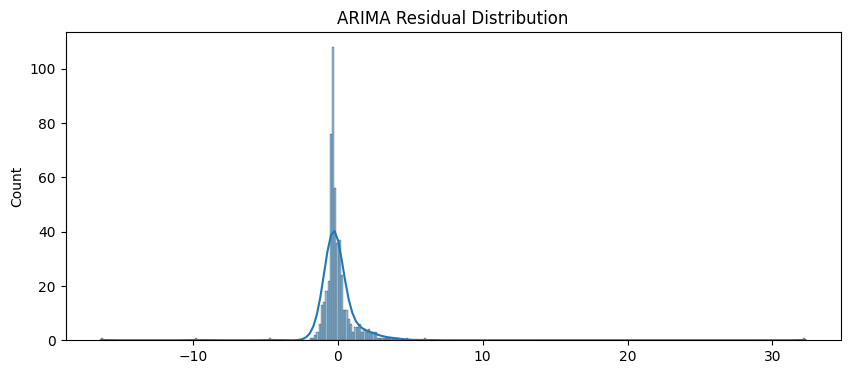

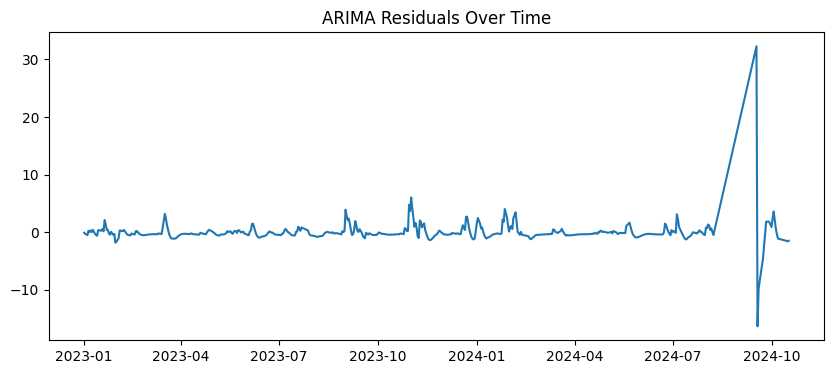

In [21]:
residuals = arima_result.resid

plt.figure(figsize=(10,4))
sns.histplot(residuals, kde=True)
plt.title("ARIMA Residual Distribution")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("ARIMA Residuals Over Time")
plt.show()

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Product_ID        511 non-null    object        
 1   Product_name      511 non-null    object        
 2   Qty               511 non-null    float64       
 3   Lead Time(days)   511 non-null    int64         
 4   Date              511 non-null    datetime64[ns]
 5   Sales             511 non-null    int64         
 6   Moving_Avg_Sales  511 non-null    float64       
 7   Cumulative_Sales  511 non-null    int64         
 8   Month             511 non-null    int64         
 9   Week              511 non-null    int64         
 10  Day_of_Week       511 non-null    int64         
 11  Lead_Time_Impact  511 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(6), object(2)
memory usage: 48.0+ KB


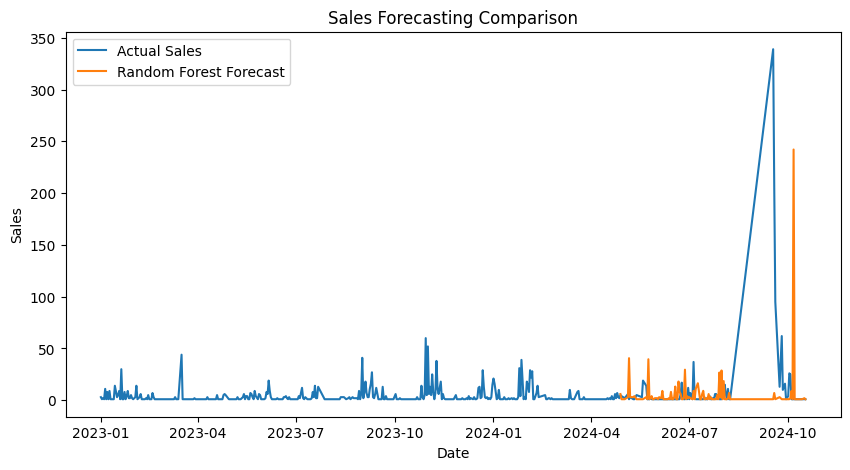

In [14]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=df['Date'], y=df['Sales'], label="Actual Sales")
sns.lineplot(x=df['Date'].iloc[-len(y_pred_rf):], y=y_pred_rf, label="Random Forest Forecast")
plt.title("Sales Forecasting Comparison")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

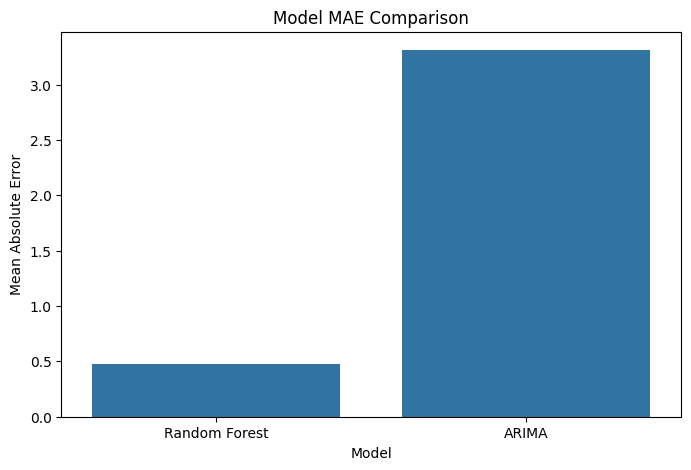

In [24]:
plt.figure(figsize=(8, 5))
sns.barplot(x=['Random Forest', 'ARIMA'], y=[rf_mae, arima_mae])
plt.title("Model MAE Comparison")
plt.xlabel("Model")
plt.ylabel("Mean Absolute Error")
plt.show()